In [1]:
from sympy import *
import networkx as nx

In [2]:
# define initial Shidoku constraints in a graph
G = nx.Graph()
for i in range(16):
    G.add_node(i)
regions = [(0,1), (0,2), (0,3), (0,4), (0,5), (0,8), (0,12),
        (1,2), (1,3), (1,4), (1,5), (1,9), (1,13),
        (2,3), (2,6), (2,7), (2,10), (2,14),
        (3,6), (3,7), (3,11), (3,15),
        (4,5), (4,6), (4,7), (4,8), (4,12),
        (5,6), (5,7), (5,9), (5,13),
        (6,7), (6,10), (6,14),
        (7,11), (7,15),
        (8,9), (8,10), (8,11), (8,12), (8,13),
        (9,10), (9,11), (9,12), (9,13),
        (10,11), (10,14), (10,15),
        (11,14), (11,15),
        (12,13), (12,14), (12,15),
        (13,14), (13,15),
        (14,15)]
G.add_edges_from(regions)

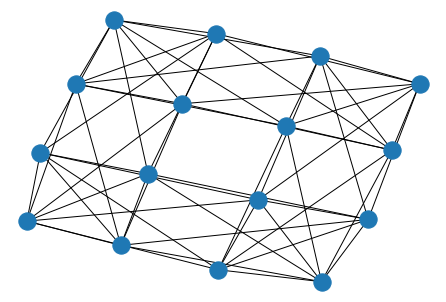

In [3]:
nx.draw(G)

In [4]:
# initialises variables to solve for
var('x')
vertices = [Symbol('x' + str(i)) for i in list(G.nodes)]
edges = [(vertices[i], vertices[j]) for i, j in list(G.edges)]

---
---

## Roots of Unity Method

In [28]:
# initialise roots of unity 
unityroots = roots(x**4 - 1, multiple=True)

In [29]:
# initialises generators of I_RoI
ideal_roi = []
for x in vertices:
    ideal_roi.append(x**4 - 1)
for x_i, x_j in edges:
    ideal_roi.append((x_i+x_j)*(x_i**2+x_j**2))
    
# add in shidoku puzzle constraints (given cells)
puzzle_clues = [Symbol('x0')+I, Symbol('x5')+1, Symbol('x7')-1, Symbol('x9')-I, Symbol('x14')-1]
ideal_roi.extend(puzzle_clues)

g_basis_roi = groebner(ideal_roi, *vertices)

In [30]:
g_basis_roi != [1]

True

In [31]:
solution_roi = solve(g_basis_roi, vertices)
solution_variables_roi = {}

for item in solution_roi:
    if solution_roi[item] == I:
        solution_variables_roi[item] = 1
    if solution_roi[item] == -1:
        solution_variables_roi[item] = 2
    if solution_roi[item] == -I:
        solution_variables_roi[item] = 3
    if solution_roi[item] == 1:
        solution_variables_roi[item] = 4
solution_variables_roi

{x0: 3,
 x1: 4,
 x2: 1,
 x3: 2,
 x4: 1,
 x5: 2,
 x6: 3,
 x7: 4,
 x8: 4,
 x9: 1,
 x10: 2,
 x11: 3,
 x12: 2,
 x13: 3,
 x14: 4,
 x15: 1}

---

---

## Sum-Product Method

In [14]:
# initialises generators of I_SP
ideal_sp = []
for x in vertices:
    ideal_sp.append((x-1)*(x-2)*(x-3)*(x-4))

# add in region constraints
for i in range(len(vertices)//4):
    # rows
    ideal_sp.append(Symbol('x' + str(4*i)) + Symbol('x' + str(4*i+1)) 
                    + Symbol('x' + str(4*i+2)) + Symbol('x' + str(4*i+3)) - 10)
    ideal_sp.append(Symbol('x' + str(4*i)) * Symbol('x' + str(4*i+1))  * 
                   Symbol('x' + str(4*i+2)) * Symbol('x' + str(4*i+3)) -24)
    # columns
    ideal_sp.append(Symbol('x' + str(i)) + Symbol('x' + str(i+4)) 
                    + Symbol('x' + str(i+8)) + Symbol('x' + str(i+12)) - 10)
    ideal_sp.append(Symbol('x' + str(i)) * Symbol('x' + str(i+4))  * 
                   Symbol('x' + str(i+8)) * Symbol('x' + str(i+12)) -24)
    
block_region_constraints_sp = [Symbol('x0') + Symbol('x1') + Symbol('x4') + Symbol('x5') - 10,
                            Symbol('x0') * Symbol('x1') * Symbol('x4') * Symbol('x5') - 24,
                            Symbol('x2') + Symbol('x3') + Symbol('x6') + Symbol('x7') - 10,
                            Symbol('x2') * Symbol('x3') * Symbol('x6') * Symbol('x7') - 24,
                            Symbol('x8') + Symbol('x9') + Symbol('x12') + Symbol('x13') - 10,
                            Symbol('x8') * Symbol('x9') * Symbol('x12') * Symbol('x13') - 24,
                            Symbol('x10') + Symbol('x11') + Symbol('x14') + Symbol('x15') - 10,
                            Symbol('x10') * Symbol('x11') * Symbol('x14') * Symbol('x15') - 24]

ideal_sp.extend(block_region_constraints_sp)
    
# add in shidoku puzzle constraints (given cells)
puzzle_clues = [Symbol('x0')-3, Symbol('x5')-2, Symbol('x7')-4, Symbol('x9')-1, Symbol('x14')-4]
ideal_sp.extend(puzzle_clues)

g_basis_sp = groebner(ideal_sp)

In [15]:
g_basis_sp != [1]

True

In [16]:
solution_sp = solve(g_basis_sp, vertices)
solution_sp

{x0: 3,
 x1: 4,
 x2: 1,
 x3: 2,
 x4: 1,
 x5: 2,
 x6: 3,
 x7: 4,
 x8: 4,
 x9: 1,
 x10: 2,
 x11: 3,
 x12: 2,
 x13: 3,
 x14: 4,
 x15: 1}

---
---

## Boolean Variable Method

In [17]:
# initialise boolean variables
boolean_variables = [Symbol('x' + str(i) + ',' + str(j)) for i in list(G.nodes) for j in range(1,5)]

In [25]:
# initialises generators of I_BV
ideal_bv = []
for x in boolean_variables:
    ideal_bv.append(x*(x-1))

# add in region constraints
for i in range(len(vertices)):
    ideal_bv.append(Symbol('x' + str(i) + ',1') + Symbol('x' + str(i) + ',2') +
                    Symbol('x' + str(i) + ',3') + Symbol('x' + str(i) + ',4') - 1)

for u,v in G.edges:
    ideal_bv.append(Symbol('x' + str(u) + ',1') * Symbol('x' + str(v) + ',1') + 
                    Symbol('x' + str(u) + ',2') * Symbol('x' + str(v) + ',2') +
                    Symbol('x' + str(u) + ',3') * Symbol('x' + str(v) + ',3') +
                    Symbol('x' + str(u) + ',4') * Symbol('x' + str(v) + ',4'))

# add in shidoku puzzle constraints (given cells)
puzzle_clues = [Symbol('x0,3')-1, Symbol('x5,2')-1, Symbol('x7,4')-1, Symbol('x9,1')-1, Symbol('x14,4')-1]
ideal_bv.extend(puzzle_clues)

g_basis_bv = groebner(ideal_bv)

In [26]:
g_basis_bv != [1]

True

In [27]:
solution_bv = solve(g_basis_bv, boolean_variables)
solution_bv_reduced = {}
for num in solution_bv:
    if solution_bv[num] != 0:
        solution_bv_reduced[num] = 1
solution_bv_reduced

{x0,3: 1,
 x1,4: 1,
 x10,2: 1,
 x11,3: 1,
 x12,2: 1,
 x13,3: 1,
 x14,4: 1,
 x15,1: 1,
 x2,1: 1,
 x3,2: 1,
 x4,1: 1,
 x5,2: 1,
 x6,3: 1,
 x7,4: 1,
 x8,4: 1,
 x9,1: 1}